Crear conexión SPARK


In [44]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Creación y aplicación del modelo").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("Ejcución de las tareas en ", cores, "core(s) del sistema de cómputo actual")

Ejcución de las tareas en  1 core(s) del sistema de cómputo actual


Carga de datos


In [45]:
from pyspark import SparkFiles
from google.colab import drive


drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Resultados_icfes_limpios (1).csv'

df00 = spark.read.csv(dataset_path, header=True, inferSchema=True)
df00.show(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+-----------+----------------+------------------------+----------------+--------------------+-----------+-----------------------+-----------------------+-----------------------+---------------+---------------+-----------------------------------+-----------------------------------+-------------+-------------+----------+----+-------------------------+-------------------------+---------------------------+-----------------------+---------------+-----------------+---------------+------------+------------+-----------+
|PUNT_GLOBAL|PUNT_C_NATURALES|PUNT_SOCIALES_CIUDADANAS|PUNT_MATEMATICAS|PUNT_LECTURA_CRITICA|PUNT_INGLES|madre_PRIMARIA_COMPLETA|padre_PREGRADO_COMPLETO|padre_PRIMARIA_COMPLETA|padre_POSTGRADO|madre_POSTGRADO|madre_TECNICO_O_TECNOLOGIA_COMPLETA|padre_TECNICO_O_TECNOLOGIA_COMPLETA|madre_NINGUNA|padre_NINGUNA|TRIMESTRES| AÑO|madre_PRIMARIA_INCOMPLETA|ma

Antes de realizar el modelo tenemos que modificar el nombre de una columna pues puede generar problemas

In [46]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


df01 = df00.withColumnRenamed(" AÑO", "ANIO")

# Definir columnas


In [47]:
categorical_cols = [
    "COLE_CALENDARIO", "COLE_CARACTER",
    "COLE_NATURALEZA", "COLE_JORNADA",
    "DEPARTAMENTO", "ESTU_GENERO"
]

exclude = [c for c in df.columns if c.startswith("PUNT_") and c != "PUNT_GLOBAL"]

numeric_cols = [
    c for c in df01.columns
    if c not in categorical_cols + ["PUNT_GLOBAL", "ANIO"] + exclude
]

# Pipeline de preprocesamiento


Indexar categorías

In [48]:
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
    for col in categorical_cols
]

One-hot encoding


In [49]:
encoder = OneHotEncoder(
    inputCols=[f"{col}_idx" for col in categorical_cols],
    outputCols=[f"{col}_ohe" for col in categorical_cols],
    handleInvalid="keep"
)

Ensamblar vector de features


In [50]:
feature_cols = numeric_cols + [f"{col}_ohe" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

prep_pipeline = Pipeline(stages=indexers + [encoder, assembler])
prep_model = prep_pipeline.fit(df01)
df_prepped = prep_model.transform(df01).select("features", "PUNT_GLOBAL")

#  Modelo Ridge (LinearRegression con regParam)

In [51]:
ridge = LinearRegression(
    featuresCol="features",
    labelCol="PUNT_GLOBAL",
    elasticNetParam=0.0,
    regParam=0.1
)
ridge_model = ridge.fit(df_prepped)

print("Intercept Ridge =", ridge_model.intercept)

Intercept Ridge = -4366.989316421158


Sacamos los coeficientes más grandes en magnitud


In [52]:
import pandas as pd
coef_list = list(zip(feature_cols, ridge_model.coefficients.toArray()))
coef_df = pd.DataFrame(coef_list, columns=["feature","coef"])
coef_df["abs_coef"] = coef_df["coef"].abs()
print("Top 10 coeficientes por magnitud:")
print(coef_df.sort_values("abs_coef", ascending=False).head(10))

Top 10 coeficientes por magnitud:
                                feature       coef   abs_coef
16                    COLE_CARACTER_ohe  34.653485  34.653485
3                       padre_POSTGRADO  32.143251  32.143251
17                  COLE_NATURALEZA_ohe -29.957351  29.957351
4                       madre_POSTGRADO  29.487931  29.487931
14              madre_PREGRADO_COMPLETO  16.263185  16.263185
1               padre_PREGRADO_COMPLETO  15.943977  15.943977
7                         madre_NINGUNA -15.553105  15.553105
9                            TRIMESTRES  13.903334  13.903334
5   madre_TECNICO_O_TECNOLOGIA_COMPLETA  10.912593  10.912593
6   padre_TECNICO_O_TECNOLOGIA_COMPLETA  10.081134  10.081134


# Random Forest con CrossValidator


In [43]:
# a) Dividir en train/test
train, test = df_prepped.randomSplit([0.8,0.2], seed=42)

# b) Definir modelo y grid de hiperparámetros
rf = RandomForestRegressor(featuresCol="features", labelCol="PUNT_GLOBAL", seed=42)
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [20, 50])
             .addGrid(rf.maxDepth, [5, 10])
             .build())

# c) Evaluador
evaluator = RegressionEvaluator(labelCol="PUNT_GLOBAL", metricName="rmse")

# d) CrossValidator
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,
                    parallelism=2)
cv_model = cv.fit(train)
best_rf = cv_model.bestModel



Exception ignored in: <function JavaWrapper.__del__ at 0x7c45ec20e0c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
                                              ^^^^^^^^^^^^^^
AttributeError: 'GBTClassifier' object has no attribute '_java_obj'


# Evaluación final

In [53]:
pred = best_rf.transform(test)
rmse = evaluator.evaluate(pred)
mae  = RegressionEvaluator(labelCol="PUNT_GLOBAL", metricName="mae").evaluate(pred)
r2   = RegressionEvaluator(labelCol="PUNT_GLOBAL", metricName="r2").evaluate(pred)

print(f"Test RMSE={rmse:.3f}, MAE={mae:.3f}, R2={r2:.3f}")

Test RMSE=39.362, MAE=31.618, R2=0.315


# Visualización de resultados con Matplotlib

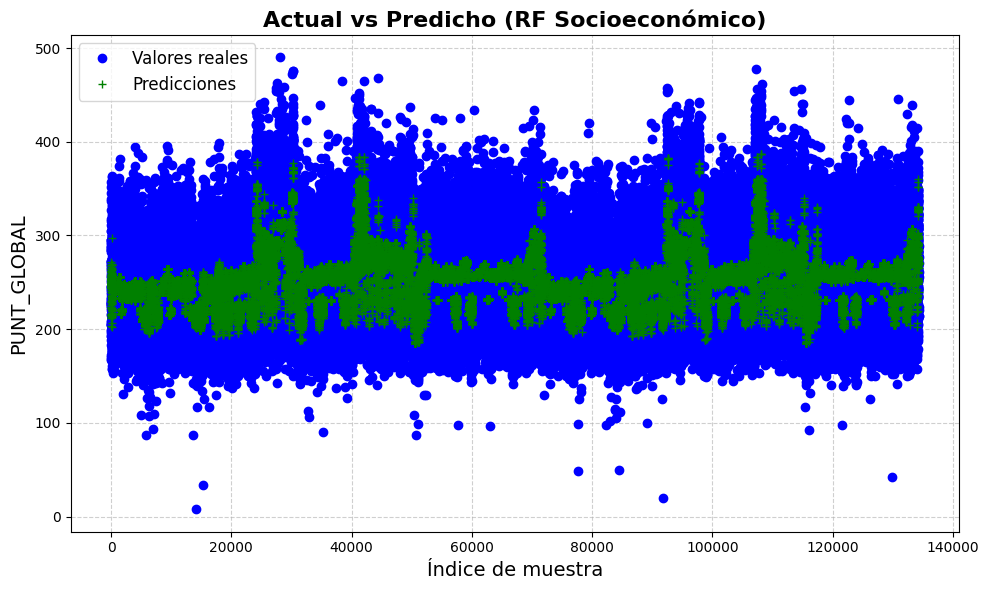

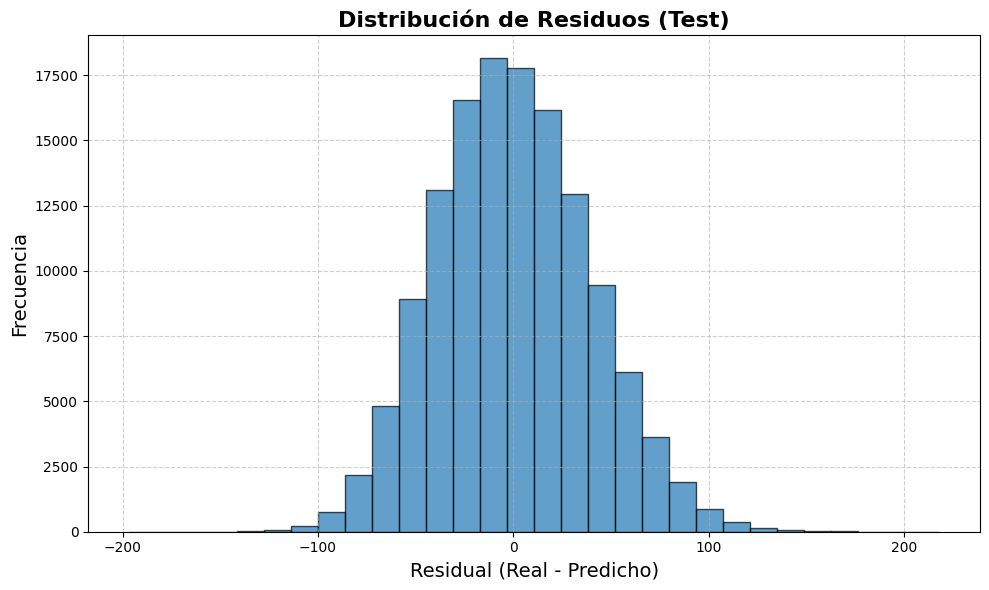

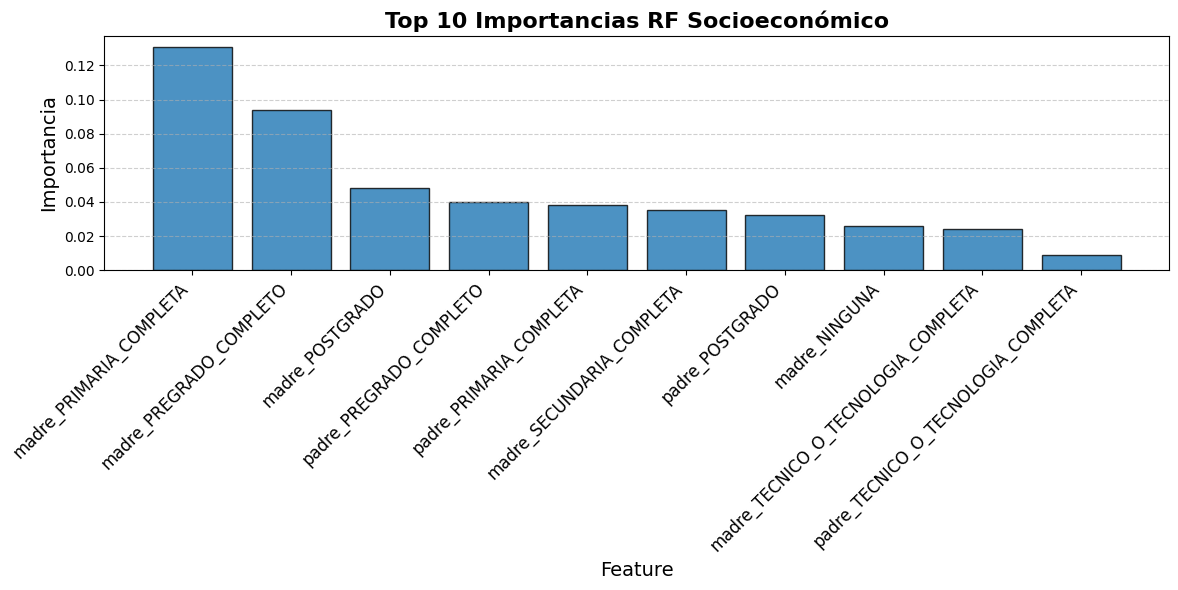

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir predicciones a pandas
pdf = pred.select("PUNT_GLOBAL", "prediction").toPandas()

# 4.2 Actual vs Predicho
plt.figure(figsize=(10, 6))
plt.plot(pdf.index, pdf["PUNT_GLOBAL"], 'bo', label="Valores reales")
plt.plot(pdf.index, pdf["prediction"], 'g+', label="Predicciones")
plt.xlabel("Índice de muestra", fontsize=14)
plt.ylabel("PUNT_GLOBAL", fontsize=14)
plt.title("Actual vs Predicho (RF Socioeconómico)", fontsize=16, fontweight="bold")
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4.3 Distribución de residuos
residuals = pdf["PUNT_GLOBAL"] - pdf["prediction"]
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Residual (Real - Predicho)", fontsize=14)
plt.ylabel("Frecuencia", fontsize=14)
plt.title("Distribución de Residuos (Test)", fontsize=16, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4.4 Top 10 importancias RF socioeconómico
importances = best_rf.featureImportances.toArray()
df_imp = pd.DataFrame(list(zip(feature_cols, importances)), columns=["feature","importance"])
df_imp = df_imp.sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(df_imp["feature"], df_imp["importance"], edgecolor="black", alpha=0.8)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.title("Top 10 Importancias RF Socioeconómico", fontsize=16, fontweight="bold")
plt.xlabel("Feature", fontsize=14)
plt.ylabel("Importancia", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()